William Iadarola

Mei Schuerch

In [9]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

# 1. Loading the Dataset

## Filtering

In [10]:
def filter(df):
  # Separates the price data so they each have a column
  df = pd.concat([df.drop(['prices'], axis=1), df['prices'].apply(pd.Series)], axis=1)  # creates new columns for each price data
  df = df[['name','mana_cost', 'type_line', 'set', 'oracle_text', 'keywords', 'rarity', 'power', 'toughness', 'usd']]
  
  # Drop rows that are non-creatures
  df = df.loc[df['type_line'].str.contains("Creature", case=False)]

  # Drop rows without a usd price
  df = df.dropna(subset=['usd', 'mana_cost', 'oracle_text', 'power', 'toughness'])  

  # Prune higher cost card varients
  df = df.sort_values(by=['usd'])
  df = df.drop_duplicates(subset=['name'], keep='first') 
  
  # Drop rows with split costs
  df = df[~df.mana_cost.str.contains('|'.join(["/"]))]

  # Prune un-sets with wack cards
  df = df[df['set'].str.contains("ust|unh|ugl|unf|und") == False]

  # Convert to lowercase for consistency
  df['type_line'] = df['type_line'].str.lower()
  df['mana_cost'] = df['mana_cost'].str.lower()

  df.reset_index(drop=True, inplace=True)
  return df

In [11]:
df = pd.read_json('/content/drive/MyDrive/ML Project/mtg_cards.json')
df_filtered = filter(df)

##Tests

In [12]:
# df_filtered.info()
df_filtered.head()
# df_filtered.isna().sum()

,name,mana_cost,type_line,set,oracle_text,keywords,rarity,power,toughness,usd
0,Blightspeaker,{1}{b},creature — human rebel cleric,tsr,"{T}: Target player loses 1 life.\n{4}, {T}: Se...",[],common,1,1,0.01
1,Hekma Sentinels,{2}{u},creature — human cleric,akh,"Whenever you cycle or discard a card, Hekma Se...",[],common,2,3,0.01
2,Dawnhart Mentor,{2}{g},creature — human warlock,mid,"When Dawnhart Mentor enters the battlefield, c...",[Coven],uncommon,0,4,0.01
3,Dawnhart Wardens,{1}{g}{w},creature — human warlock,mid,Vigilance\nCoven — At the beginning of combat ...,"[Vigilance, Coven]",uncommon,3,3,0.01
4,Daybreak Combatants,{2}{r},creature — human warrior,vow,Haste\nWhen Daybreak Combatants enters the bat...,[Haste],common,2,2,0.01


# 2. Preprocessing & Model Selection

In [13]:
def transform(df):
  N = len(df)

  # Power/Toughness (*-values)
  star = {'power_*' : [0]*N,
          'toughness_*' : [0]*N}

  # Oracle Text:
  vectorizer = CountVectorizer()
  oracle_text_list = df['oracle_text'].tolist()
  bow = vectorizer.fit_transform(oracle_text_list)
  count_vect_df = pd.DataFrame(bow.todense(), columns=vectorizer.get_feature_names_out())

  # Keywords: Bag of Words
  key_count = {}

  # Rarity: Ordinal Encoding
  rarity_map = {'common': 0.0,'uncommon': 1.0,'rare': 2.0,'mythic': 3.0,'special': 1.5}
  df['rarity'] = df['rarity'].apply(lambda r: rarity_map[r] if r in rarity_map.keys() else r)

  # Type Line: One Hot Encoding
  types = {}
  df['type_line'] = df['type_line'].apply(lambda val: val[val.find('—')+1:]) # Prune the 'Creature -' from the type line
  
  # Colors: Bag of Words
  colors = ['c','r','g','u','w','b','x','s','v']  # [colorless, red, green, blue, white, black, x, snow, generic]
  color_counts = {}  # Create a collection of mana cost color counts for each card
  for color in colors:
    color_counts['cost_%s' % color] = [0] * N
  
  # Update the dictionaries with the various counts
  for i in range(N):
    # Color
    cost = df.iloc[i]['mana_cost'].replace('{','').replace('}','')
    generic = [int(num) for num in re.findall(r"\d+", cost)]
    if len(generic) == 1: color_counts['cost_v'][i] = generic[0]
    for char in cost:
        if not char.isnumeric(): color_counts['cost_%s' % char][i] += 1
    # Type Line
    type_line = df.iloc[i]['type_line']
    type_line = type_line.split()
    for name in type_line:
      type_name = 'type_%s' % name
      if type_name not in types.keys(): types[type_name] = [0]*N
      types[type_name][i] += 1
    # Keywords
    keywords = df.iloc[i]['keywords']
    for keyword in keywords:
      key = 'kw_%s' % keyword.lower()
      if key not in key_count.keys(): key_count[key] = [0]*N
      if df.iloc[i]['name'] == 'Apex Devastator': key_count[key][i] = 4
      else: key_count[key][i] = 1
    # Power
    if not df.iloc[i]['power'].isnumeric() and '*' in df.iloc[i]['power']: 
      star['power_*'][i] = 1
      df.at[i, 'power'] = 0
    # Toughness
    if not df.iloc[i]['toughness'].isnumeric() and '*' in df.iloc[i]['toughness']: 
      star['toughness_*'][i] = 1
      df.at[i, 'toughness'] = 0
  
  # Prune unique keywords because they wont ever repeat in new cards (probably)
  unique_keys = []
  for key in key_count.keys():
    count = 0
    for i in range(len(key_count[key])):
      val = key_count[key][i]
      if val == 1: count += 1
    if count == 1: unique_keys.append(key)
  for key in unique_keys:
    del key_count[key]

  # Update the dataframe with new features
  df = pd.concat([df, count_vect_df], axis=1)
  df = pd.concat([df, pd.DataFrame.from_dict(color_counts).set_axis(df.index)], axis=1)
  df = pd.concat([df, pd.DataFrame.from_dict(types).set_axis(df.index)], axis=1)
  df = pd.concat([df, pd.DataFrame.from_dict(key_count).set_axis(df.index)], axis=1)
  df = pd.concat([df, pd.DataFrame.from_dict(star).set_axis(df.index)], axis=1)

  # Drop the original uneeded columns
  df = df.drop(columns=['mana_cost', 'type_line', 'keywords', 'oracle_text', 'name', 'set'])

  return df

df_transformed = transform(df_filtered)
df_transformed.head()

,rarity,power,toughness,usd,10,11,12,13,14,15,...,kw_desertwalk,kw_friends forever,kw_annihilator,kw_champion,kw_grandeur,kw_horsemanship,kw_lieutenant,kw_offering,power_*,toughness_*
0,0.0,1,1,0.01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,2,3,0.01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,4,0.01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,3,3,0.01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,2,2,0.01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Transforming & Scaling
df_transformed.drop(df_transformed.tail(1).index,inplace=True)
X = df_transformed.loc[:, df_transformed.columns != 'usd']
scalar = MinMaxScaler()
X_scaled = scalar.fit_transform(X)
y = df_transformed[['usd']]

# 3. Running the Algorithms

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier

# Test Train Validation Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.to_numpy(), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [16]:
from sklearn.metrics import confusion_matrix

##Linear Regression

In [17]:
lin = LinearRegression().fit(X_train, y_train)
lin_res = ( lin.score(X_train, y_train) , lin.score(X_val, y_val) )

In [18]:
print("Linear Regression Accuracy: {p}".format(p=lin_res))

Linear Regression Accuracy: (0.8735691331834832, -7.148704120446791e+22)


In [19]:
lin_test = lin.predict(X_test)
lin_test_score = lin.score(X_test, y_test)

print(lin_test_score)

-3.3944199200819154e+23


## Lasso Regression

In [20]:
lso_alpha = [0.1, 0.05, 0.01, 0.001]
lso_res = {}
for a in lso_alpha:
  lso = Lasso(alpha=a).fit(X_train, y_train)
  lso_res[a] = ( lso.score(X_train, y_train) , lso.score(X_val, y_val) )

In [21]:
for alpha in lso_res.keys():
  print("Alpha = {a}: accuracy = {p}".format(a=alpha, p=lso_res[alpha]))

Alpha = 0.1: accuracy = (0.05746344768338729, 0.08706355438477653)
Alpha = 0.05: accuracy = (0.19170728735792386, 0.3401385219416847)
Alpha = 0.01: accuracy = (0.5458120378518474, 0.4121224923916318)
Alpha = 0.001: accuracy = (0.7577522099250565, 0.32360162149325666)


In [22]:
lso = Lasso(alpha=0.01).fit(X_train, y_train)

lso_test = lso.predict(X_test)
lso_test_score = lso.score(X_test, y_test)

print(lso_test_score)

-0.02073787601899646


##Ridge regression 

In [23]:
rdg_alpha = [1, 3, 5, 10]
rdg_res = {}
for a in rdg_alpha:
  rdg = Ridge(alpha=a).fit(X_train, y_train)
  rdg_res[a] = ( rdg.score(X_train, y_train) , rdg.score(X_val, y_val) )

In [24]:
for alpha in rdg_res.keys():
  print("Alpha = {a}: accuracy = {p}".format(a=alpha, p=rdg_res[alpha]))

Alpha = 1: accuracy = (0.7300607917177727, 0.28036425190345715)
Alpha = 3: accuracy = (0.6260780818194299, 0.3204481179258091)
Alpha = 5: accuracy = (0.5638673057765654, 0.3264349773062353)
Alpha = 10: accuracy = (0.46978167131397097, 0.31785966465069637)


## Graphs

In [25]:
from sklearn.metrics import RocCurveDisplay

rdg_mod = Ridge(alpha=3).fit(X_train, y_train)

In [28]:
rdg_disp = RocCurveDisplay.from_predictions(rdg_mod, X_test, y_test)

ax = plt.gca()
lso_disp = RocCurveDisplay.from_estimator(lso_test, X_test, y_test, ax=ax, alpha=0.8)
rdg_disp.plot(ax=ax, alpha=0.8)

TypeError: ignored

##Logistic Regression

In [30]:
C = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]

# Modifying y for logistic regression -> 0,1 for if price is above or below 50c
y_lr_train = np.apply_along_axis(lambda v: 0 if float(v) > 1 else 1, 1, y_train)
y_lr_val = np.apply_along_axis(lambda v: 0 if float(v) > 1 else 1, 1, y_val)
y_lr_test = np.apply_along_axis(lambda v: 0 if float(v) > 1 else 1, 1, y_test)

# log_res = []
# for c_val in C:
#   log = LogisticRegression(C=c_val, max_iter=400).fit(X_train, y_lr_train.ravel())
#   log_res.append((c_val, (log.score(X_train, y_lr_train), log.score(X_val, y_lr_val))))

In [ ]:
for pair in log_res:
  print(pair)

(1e-07, (0.8616682805367271, 0.8726141078838174))
(1e-05, (0.8616682805367271, 0.8726141078838174))
(0.001, (0.8616682805367271, 0.8726141078838174))
(0.01, (0.8616682805367271, 0.8726141078838174))
(0.1, (0.8921012588186471, 0.8900414937759336))
(1, (0.9383040531193803, 0.8921161825726142))
(10, (0.9778669248858763, 0.8846473029045643))
(100, (0.9894867893207913, 0.866390041493776))
(10000, (0.9968183704523447, 0.7987551867219918))
(1000000, (0.9977866924885876, 0.7858921161825726))


In [31]:
log_mod = LogisticRegression(C=1, max_iter=400).fit(X_train, y_lr_train.ravel())
# print(log_mod.score(X_test, y_lr_test))
# confusion_matrix(y_lr_test, log_mod.predict(X_test))

##SVM

In [ ]:
C = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100,10000, 1000000]

svm_res = []
for c_val in C:
  print("Running",c_val)
  svm = SVC(C = c_val, gamma='auto').fit(X_train, y_lr_train.ravel())
  svm_res.append((c_val, (svm.score(X_train, y_lr_train), svm.score(X_val, y_lr_val))))

Running 1e-07
Running 1e-05
Running 0.001
Running 0.01
Running 0.1
Running 1
Running 10
Running 100
Running 10000
Running 1000000


In [ ]:
for pair in svm_res:
  print(pair)

(1e-07, (0.8616682805367271, 0.8726141078838174))
(1e-05, (0.8616682805367271, 0.8726141078838174))
(0.001, (0.8616682805367271, 0.8726141078838174))
(0.01, (0.8616682805367271, 0.8726141078838174))
(0.1, (0.8921012588186471, 0.8900414937759336))
(1, (0.9383040531193803, 0.8921161825726142))
(10, (0.9778669248858763, 0.8846473029045643))
(100, (0.9894867893207913, 0.866390041493776))
(10000, (0.9968183704523447, 0.7987551867219918))
(1000000, (0.9977866924885876, 0.7858921161825726))


In [32]:
svm_mod = SVC(C=10000, gamma='auto').fit(X_train, y_lr_train.ravel())
# print(svm_mod.score(X_test, y_lr_test))
# confusion_matrix(y_lr_test, svm_mod.predict(X_test))

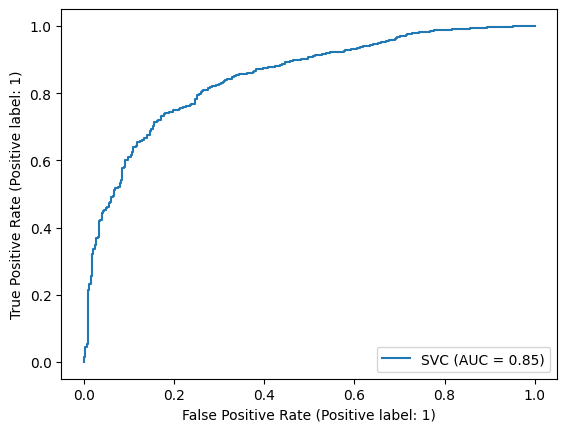

In [35]:
svc_disp = RocCurveDisplay.from_estimator(svm_mod, X_test, y_lr_test)

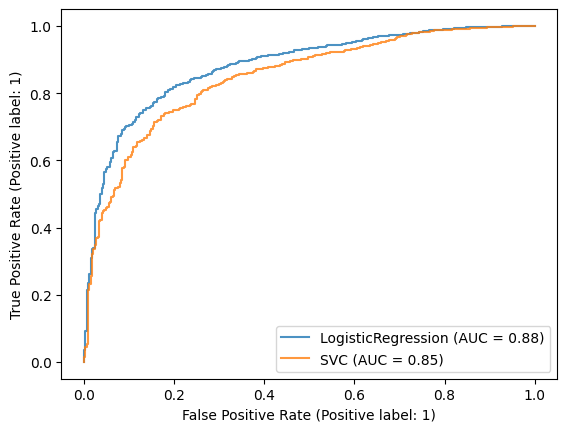

In [36]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(log_mod, X_test, y_lr_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)

##Neural Network - Regressor

In [ ]:
# MLP = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train.ravel())

# print("MLP Train Set Score: ", MLP.score(X_train, y_train))
# print("MLP Validation Set Score: ", MLP.score(X_val, y_val))

## Neural Network - Classifier

In [ ]:
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1, max_iter=500).fit(X_train, y_train.ravel())

# print("MLP Train Set Score: ", clf.score(X_train, y_train))
# print("MLP Train Set Score: ", clf.score(X_val, y_val))

In [ ]:
#Scoring

from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

log_test = log_mod.predict(X_test)
svm_test = svm_mod.predict(X_test)

print("Linear Regression w/ Lasso:", average_precision_score(y_test, lso_test), recall_score(y_test, lso_test, average='macro'))
print("Logistic Regression:", average_precision_score(y_lr_test, log_test), recall_score(y_lr_test, log_test, average='macro'))
print("SVM:", average_precision_score(y_lr_test, svm_test), recall_score(y_lr_test, svm_test, average='macro'))


ValueError: ignored